In [4]:
# ====================================================================================
# CELL 1 – Imports & global settings
# ====================================================================================

import os, random, itertools, warnings, math, json, time, copy
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torchvision.transforms as T
import torchvision.models as models

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8,6)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED   = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print(f'Running on {DEVICE}')


Running on cpu


In [5]:
# ====================================================================================
# CELL 2 – Paths & transforms
# ====================================================================================

# Point to your un-zipped Kaggle copy of LFW
LFW_ROOT = Path(r"C:\Users\premy\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4\lfw-deepfunneled\lfw")

assert LFW_ROOT.exists(), f"LFW directory not found: {LFW_ROOT}"

transform_train = T.Compose([
    T.Resize((224,224)),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(10),
    T.ColorJitter(brightness=.2, contrast=.2),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

transform_test = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [6]:
# ====================================================================================
# CELL 3 – LFW single-image dataset
# ====================================================================================
from PIL import Image

class LFWDataset(Dataset):
    def __init__(self, root_dir:Path, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        
        self.people = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.image_paths, self.labels = [], []
        for idx, person in enumerate(self.people):
            for img_file in (self.root_dir/person).glob('*'):
                if img_file.suffix.lower() in {'.jpg','.jpeg','.png'}:
                    self.image_paths.append(img_file)
                    self.labels.append(idx)
        print(f'LFW: {len(self.image_paths)} images, {len(self.people)} identities')
    
    def __len__(self): return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]


In [7]:
# ====================================================================================
# CELL 4 – Pair & triplet dataset helpers
# ====================================================================================

class SiamesePairs(Dataset):
    def __init__(self, base_ds:Dataset, num_pairs:int=5000):
        self.base_ds = base_ds
        self.num_pairs = num_pairs

        # group indices by label
        self.label_idx = {}
        for i, (_, lbl) in enumerate(base_ds):
            self.label_idx.setdefault(lbl, []).append(i)
        self.labels, self.pairs = [], []

        # Only use labels with at least 2 samples for positive pairs
        valid_labels = [lbl for lbl, idxs in self.label_idx.items() if len(idxs) >= 2]

        # positive pairs
        for _ in range(num_pairs // 2):
            if not valid_labels:
                break  # no way to generate more positive pairs
            lbl = random.choice(valid_labels)
            i1, i2 = random.sample(self.label_idx[lbl], 2)
            self.pairs.append((i1, i2)); self.labels.append(1)

        # negative pairs
        labels = list(self.label_idx.keys())
        for _ in range(num_pairs // 2):
            lbl1, lbl2 = random.sample(labels, 2)
            i1 = random.choice(self.label_idx[lbl1])
            i2 = random.choice(self.label_idx[lbl2])
            self.pairs.append((i1, i2)); self.labels.append(0)

    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        i1, i2 = self.pairs[idx]
        img1, _ = self.base_ds[i1]
        img2, _ = self.base_ds[i2]
        return img1, img2, torch.tensor(self.labels[idx], dtype=torch.float32)

class TripletSet(Dataset):
    def __init__(self, base_ds: Dataset, num_triplets: int = 5000):
        self.base_ds = base_ds
        self.triplets = []
        label_idx = {}

        # Group samples by label
        for i, (_, lbl) in enumerate(base_ds):
            label_idx.setdefault(lbl, []).append(i)
        
        # Filter labels with at least 2 samples (for anchor-positive)
        valid_labels = [lbl for lbl, idxs in label_idx.items() if len(idxs) >= 2]
        labels = list(label_idx.keys())

        if len(valid_labels) == 0:
            raise ValueError("No label has at least 2 samples to form anchor-positive pairs.")

        if len(labels) < 2:
            raise ValueError("Not enough distinct labels to form negative samples.")

        # Generate triplets
        while len(self.triplets) < num_triplets:
            a_lbl = random.choice(valid_labels)  # Anchor label with >=2 samples
            n_lbl_candidates = [l for l in labels if l != a_lbl]
            if not n_lbl_candidates:
                break  # no negatives to pick
            n_lbl = random.choice(n_lbl_candidates)

            a, p = random.sample(label_idx[a_lbl], 2)  # distinct anchor and positive
            n = random.choice(label_idx[n_lbl])        # negative

            self.triplets.append((a, p, n))

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        a, p, n = self.triplets[idx]
        return self.base_ds[a][0], self.base_ds[p][0], self.base_ds[n][0]


In [8]:
# ====================================================================================
# CELL 5 – Backbone architectures
# ====================================================================================

# 1. Simple MLP for 224×224 RGB images (flattened)
class MLPBackbone(nn.Module):
    def __init__(self, emb_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(224*224*3, 1024), nn.ReLU(),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.Linear(512, emb_dim)
        )
    def forward(self,x): return F.normalize(self.net(x),p=2,dim=1)

# 2. Shallow CNN
class ShallowCNN(nn.Module):
    def __init__(self, emb_dim=128):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,1,1), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(128, emb_dim)
    def forward(self,x): return F.normalize(self.fc(self.features(x).squeeze()),2,1)

# 3. Deep CNN (ResNet-18 pre-trained)
class DeepCNN(nn.Module):
    def __init__(self, emb_dim=128):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, emb_dim)
    def forward(self,x): return F.normalize(self.backbone(x),2,1)

# 4. MobileNetV2 pre-trained
class MobileNetBackbone(nn.Module):
    def __init__(self, emb_dim=128):
        super().__init__()
        self.backbone = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.backbone.last_channel, emb_dim)
        )
    def forward(self,x): return F.normalize(self.backbone(x),2,1)


In [9]:
# ====================================================================================
# CELL 6 – Loss functions
# ====================================================================================

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0): super().__init__(); self.margin=margin
    def forward(self,z1,z2,y):
        d = F.pairwise_distance(z1,z2)
        return torch.mean(y*d.pow(2) + (1-y)*F.relu(self.margin-d).pow(2))

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0): super().__init__(); self.margin=margin
    def forward(self,a,p,n):
        return torch.mean(F.relu(
            F.pairwise_distance(a,p) - F.pairwise_distance(a,n) + self.margin))

# Built-in PyTorch cosine embedding loss (expects targets 1/-1)
cos_emb_loss = nn.CosineEmbeddingLoss()

# Simple InfoNCE (assumes batch has positive pairs in consecutive rows)
class InfoNCELoss(nn.Module):
    def __init__(self, temperature=0.07): super().__init__(); self.t=temperature
    def forward(self, z):                 # z shape (2B, emb)
        B = z.shape[0]//2
        z = F.normalize(z, dim=1)
        sim = torch.mm(z, z.t())/self.t
        labels = torch.cat([torch.arange(B) for _ in range(2)],0).to(z.device)
        return F.cross_entropy(sim, labels)


In [10]:
# ====================================================================================
# CELL 7 – Siamese & Triplet wrappers
# ====================================================================================

class Siamese(nn.Module):
    def __init__(self, backbone): super().__init__(); self.backbone = backbone
    def forward(self,x1,x2): return self.backbone(x1), self.backbone(x2)
    def embed(self,x): return self.backbone(x)


In [11]:
# ====================================================================================
# CELL 8 – Training helpers
# ====================================================================================

def train_epoch_siam(model, loader, criterion, optimiser):
    model.train(); running=0
    for (x1,x2,y) in loader:
        x1,x2,y = x1.to(DEVICE),x2.to(DEVICE),y.to(DEVICE)
        optimiser.zero_grad()
        z1,z2 = model(x1,x2)
        loss = criterion(z1,z2,y)
        loss.backward(); optimiser.step()
        running += loss.item()*x1.size(0)
    return running/len(loader.dataset)

def train_epoch_triplet(model, loader, criterion, optimiser):
    model.train(); running=0
    for (a,p,n) in loader:
        a,p,n = a.to(DEVICE),p.to(DEVICE),n.to(DEVICE)
        optimiser.zero_grad()
        loss = criterion(model.embed(a), model.embed(p), model.embed(n))
        loss.backward(); optimiser.step()
        running += loss.item()*a.size(0)
    return running/len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    sims, labels = [], []
    for x1,x2,y in loader:
        z1,z2 = model(x1.to(DEVICE),x2.to(DEVICE))
        sims.extend(F.cosine_similarity(z1,z2).cpu().numpy())
        labels.extend(y.numpy())
    sims = np.array(sims); labels=np.array(labels)
    auc = roc_auc_score(labels, sims)
    best_acc, best_th = 0,0
    for t in np.linspace(-1,1,200):
        acc = accuracy_score(labels, (sims>t).astype(int))
        if acc>best_acc: best_acc, best_th = acc,t
    return auc, best_acc, best_th


In [12]:
# ====================================================================================
# CELL 9 – t-SNE visualisation
# ====================================================================================

@torch.no_grad()
def plot_tsne(model, dataset, n_samples=1000):
    model.eval()
    idxs = random.sample(range(len(dataset)), n_samples)
    imgs = torch.stack([dataset[i][0] for i in idxs]).to(DEVICE)
    labels = np.array([dataset[i][1] for i in idxs])
    emb = model.embed(imgs).cpu().numpy()
    emb = StandardScaler().fit_transform(emb)
    tsne = TSNE(n_components=2, init='random', learning_rate='auto',
                perplexity=30, max_iter=1000, random_state=SEED).fit_transform(emb)
    plt.figure(figsize=(7,7))
    scatter = plt.scatter(tsne[:,0], tsne[:,1], c=labels, cmap='tab20', s=8)
    plt.title('t-SNE embeddings'); plt.axis('off')
    return plt.gcf()


In [17]:
# ====================================================================================
# CELL 9 – t-SNE visualisation
# ====================================================================================

@torch.no_grad()
def plot_tsne(model, dataset, n_samples=1000):
    model.eval()
    total = len(dataset)
    actual_n = min(n_samples, total)
    idxs = random.sample(range(total), actual_n)
    imgs = torch.stack([dataset[i][0] for i in idxs]).to(DEVICE)
    labels = np.array([dataset[i][1] for i in idxs])
    emb = model.embed(imgs).cpu().numpy()
    emb = StandardScaler().fit_transform(emb)
    tsne = TSNE(n_components=2, init='random', learning_rate='auto',
                perplexity=30, max_iter=1000, random_state=SEED).fit_transform(emb)
    plt.figure(figsize=(7,7))
    scatter = plt.scatter(tsne[:,0], tsne[:,1], c=labels, cmap='tab20', s=8)
    plt.title('t-SNE embeddings'); plt.axis('off')
    return plt.gcf()


In [18]:
# ====================================================================================
# CELL 10 – Data preparation (train/test split & loaders)
# ====================================================================================

full_ds = LFWDataset(LFW_ROOT, transform=transform_train)
train_size = int(0.8*len(full_ds))
test_size  = len(full_ds)-train_size
train_base, test_base = random_split(full_ds,[train_size,test_size])

train_pairs = SiamesePairs(train_base, num_pairs=300)
test_pairs  = SiamesePairs(test_base,  num_pairs=150)
train_trip  = TripletSet(train_base,   num_triplets=300)

BATCH = 32
train_loader_pairs = DataLoader(train_pairs, batch_size=BATCH, shuffle=True)
test_loader_pairs  = DataLoader(test_pairs,  batch_size=BATCH)
train_loader_trip  = DataLoader(train_trip,  batch_size=BATCH, shuffle=True)


LFW: 13233 images, 5749 identities


In [19]:
from collections import Counter

label_counts = Counter([lbl for _, lbl in train_base])
num_labels_2plus = sum(1 for c in label_counts.values() if c >= 2)
print(f"Number of labels with at least 2 images: {num_labels_2plus}")


Number of labels with at least 2 images: 1365



=== MLP + Contrastive ===
Epoch 1: loss 0.3249
Epoch 2: loss 0.2729
Epoch 3: loss 0.2545
→ AUC 0.645 | Acc 0.627 @ thr 0.89

=== MLP + Cosine ===
Epoch 1: loss 0.4918
Epoch 2: loss 0.4783
Epoch 3: loss 0.4476
→ AUC 0.676 | Acc 0.640 @ thr 0.55

=== MLP + InfoNCE ===
Epoch 1: loss 3.7845
Epoch 2: loss 3.5936
Epoch 3: loss 3.5137
→ AUC 0.604 | Acc 0.600 @ thr 0.92

=== MLP + Triplet ===
Epoch 1: loss 0.9429
Epoch 2: loss 0.8330
Epoch 3: loss 0.7886


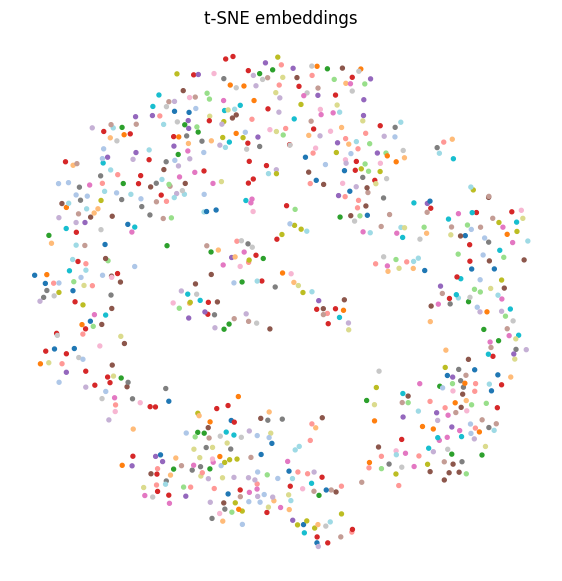

In [20]:
# ====================================================================================
# CELL 1 – MLP experiments
# ====================================================================================
arch_name = 'MLP'
Arch = MLPBackbone

loss_funcs = {
    'Contrastive': ContrastiveLoss(),
    'Cosine':      lambda z1,z2,y: cos_emb_loss(z1,z2,(2*y-1)),
    'InfoNCE':     InfoNCELoss(),
}

results = []

for loss_name, loss_fn in loss_funcs.items():
    print(f'\n=== {arch_name} + {loss_name} ===')
    model = Siamese(Arch().to(DEVICE))
    opt = optim.Adam(model.parameters(), lr=1e-3)

    if loss_name == 'InfoNCE':
        def epoch():
            model.train(); running = 0
            for x1, x2, _ in train_loader_pairs:
                x = torch.cat([x1, x2], 0).to(DEVICE)
                opt.zero_grad()
                loss = loss_fn(model.embed(x))
                loss.backward(); opt.step()
                running += loss.item() * x1.size(0)
            return running / len(train_loader_pairs.dataset)
        train_fn = epoch
    else:
        train_fn = lambda: train_epoch_siam(model, train_loader_pairs, loss_fn, opt)

    for ep in range(3):
        l = train_fn(); print(f'Epoch {ep+1}: loss {l:.4f}')
    auc, acc, th = evaluate(model, test_loader_pairs)
    print(f'→ AUC {auc:.3f} | Acc {acc:.3f} @ thr {th:.2f}')
    results.append(dict(Arch=arch_name, Loss=loss_name, AUC=auc, Acc=acc, Threshold=th))

# Triplet loss
print(f'\n=== {arch_name} + Triplet ===')
model = Siamese(Arch().to(DEVICE))
opt = optim.Adam(model.parameters(), lr=1e-3)
for ep in range(3):
    l = train_epoch_triplet(model, train_loader_trip, TripletLoss(), opt)
    print(f'Epoch {ep+1}: loss {l:.4f}')
auc, acc, th = evaluate(model, test_loader_pairs)
results.append(dict(Arch=arch_name, Loss='Triplet', AUC=auc, Acc=acc, Threshold=th))
plot_tsne(model, test_base, min(800, len(test_base))); plt.show()


In [ ]:
# ====================================================================================
# CELL 2 – ShallowCNN experiments
# ====================================================================================
arch_name = 'ShallowCNN'
Arch = ShallowCNN

for loss_name, loss_fn in loss_funcs.items():
    print(f'\n=== {arch_name} + {loss_name} ===')
    model = Siamese(Arch().to(DEVICE))
    opt = optim.Adam(model.parameters(), lr=1e-3)

    if loss_name == 'InfoNCE':
        def epoch():
            model.train(); running = 0
            for x1, x2, _ in train_loader_pairs:
                x = torch.cat([x1, x2], 0).to(DEVICE)
                opt.zero_grad()
                loss = loss_fn(model.embed(x))
                loss.backward(); opt.step()
                running += loss.item() * x1.size(0)
            return running / len(train_loader_pairs.dataset)
        train_fn = epoch
    else:
        train_fn = lambda: train_epoch_siam(model, train_loader_pairs, loss_fn, opt)

    for ep in range(3):
        l = train_fn(); print(f'Epoch {ep+1}: loss {l:.4f}')
    auc, acc, th = evaluate(model, test_loader_pairs)
    print(f'→ AUC {auc:.3f} | Acc {acc:.3f} @ thr {th:.2f}')
    results.append(dict(Arch=arch_name, Loss=loss_name, AUC=auc, Acc=acc, Threshold=th))

print(f'\n=== {arch_name} + Triplet ===')
model = Siamese(Arch().to(DEVICE))
opt = optim.Adam(model.parameters(), lr=1e-3)
for ep in range(3):
    l = train_epoch_triplet(model, train_loader_trip, TripletLoss(), opt)
    print(f'Epoch {ep+1}: loss {l:.4f}')
auc, acc, th = evaluate(model, test_loader_pairs)
results.append(dict(Arch=arch_name, Loss='Triplet', AUC=auc, Acc=acc, Threshold=th))
# Reduce the number of samples for t-SNE to avoid memory errors
plot_tsne(model, test_base, min(200, len(test_base))); plt.show()



=== ShallowCNN + Contrastive ===
Epoch 1: loss 0.2880
Epoch 2: loss 0.2673
Epoch 3: loss 0.2728
→ AUC 0.543 | Acc 0.560 @ thr 0.82

=== ShallowCNN + Cosine ===
Epoch 1: loss 0.4981
Epoch 2: loss 0.4708
Epoch 3: loss 0.4747
→ AUC 0.530 | Acc 0.567 @ thr 0.95

=== ShallowCNN + InfoNCE ===
Epoch 1: loss 3.8083
Epoch 2: loss 3.6813
Epoch 3: loss 3.6123
→ AUC 0.571 | Acc 0.580 @ thr 0.93

=== ShallowCNN + Triplet ===
Epoch 1: loss 0.9721
Epoch 2: loss 0.9839
Epoch 3: loss 0.9817


RuntimeError: [enforce fail at alloc_cpu.cpp:116] data. DefaultCPUAllocator: not enough memory: you tried to allocate 5138022400 bytes.


=== DeepCNN + Contrastive ===
Epoch 1: loss 0.2486
Epoch 2: loss 0.1904
Epoch 3: loss 0.1628
→ AUC 0.767 | Acc 0.740 @ thr 0.88

=== DeepCNN + Cosine ===
Epoch 1: loss 0.4804
Epoch 2: loss 0.4264
Epoch 3: loss 0.3918
→ AUC 0.535 | Acc 0.567 @ thr 0.36

=== DeepCNN + InfoNCE ===
Epoch 1: loss 2.9733
Epoch 2: loss 2.7457
Epoch 3: loss 2.5538
→ AUC 0.701 | Acc 0.673 @ thr 0.77

=== DeepCNN + Triplet ===
Epoch 1: loss 0.7286
Epoch 2: loss 0.4631
Epoch 3: loss 0.3536


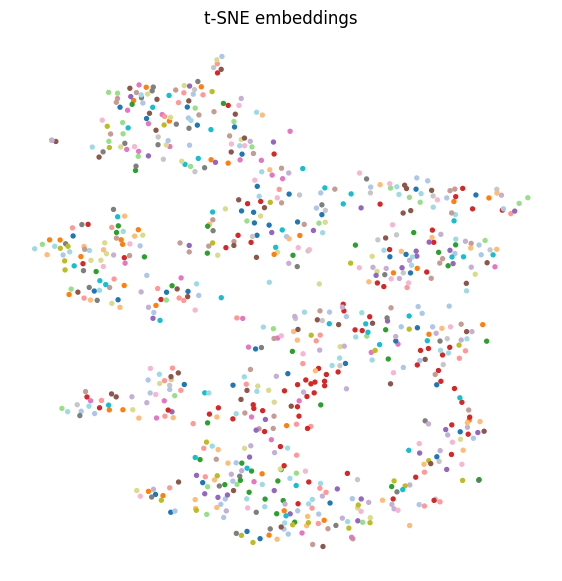

In [22]:
# ====================================================================================
# CELL 3 – DeepCNN experiments
# ====================================================================================
arch_name = 'DeepCNN'
Arch = DeepCNN

for loss_name, loss_fn in loss_funcs.items():
    print(f'\n=== {arch_name} + {loss_name} ===')
    model = Siamese(Arch().to(DEVICE))
    opt = optim.Adam(model.parameters(), lr=1e-3)

    if loss_name == 'InfoNCE':
        def epoch():
            model.train(); running = 0
            for x1, x2, _ in train_loader_pairs:
                x = torch.cat([x1, x2], 0).to(DEVICE)
                opt.zero_grad()
                loss = loss_fn(model.embed(x))
                loss.backward(); opt.step()
                running += loss.item() * x1.size(0)
            return running / len(train_loader_pairs.dataset)
        train_fn = epoch
    else:
        train_fn = lambda: train_epoch_siam(model, train_loader_pairs, loss_fn, opt)

    for ep in range(3):
        l = train_fn(); print(f'Epoch {ep+1}: loss {l:.4f}')
    auc, acc, th = evaluate(model, test_loader_pairs)
    print(f'→ AUC {auc:.3f} | Acc {acc:.3f} @ thr {th:.2f}')
    results.append(dict(Arch=arch_name, Loss=loss_name, AUC=auc, Acc=acc, Threshold=th))

print(f'\n=== {arch_name} + Triplet ===')
model = Siamese(Arch().to(DEVICE))
opt = optim.Adam(model.parameters(), lr=1e-3)
for ep in range(3):
    l = train_epoch_triplet(model, train_loader_trip, TripletLoss(), opt)
    print(f'Epoch {ep+1}: loss {l:.4f}')
auc, acc, th = evaluate(model, test_loader_pairs)
results.append(dict(Arch=arch_name, Loss='Triplet', AUC=auc, Acc=acc, Threshold=th))
plot_tsne(model, test_base, min(500, len(test_base))); plt.show()



=== MobileNetV2 + Contrastive ===
Epoch 1: loss 0.3092
Epoch 2: loss 0.1968
Epoch 3: loss 0.1483
→ AUC 0.826 | Acc 0.767 @ thr 0.92

=== MobileNetV2 + Cosine ===
Epoch 1: loss 0.4803
Epoch 2: loss 0.2908
Epoch 3: loss 0.2037
→ AUC 0.716 | Acc 0.667 @ thr 0.45

=== MobileNetV2 + InfoNCE ===
Epoch 1: loss 3.3515
Epoch 2: loss 2.5546
Epoch 3: loss 2.2429
→ AUC 0.813 | Acc 0.747 @ thr 0.78

=== MobileNetV2 + Triplet ===
Epoch 1: loss 0.8845
Epoch 2: loss 0.4746
Epoch 3: loss 0.3492


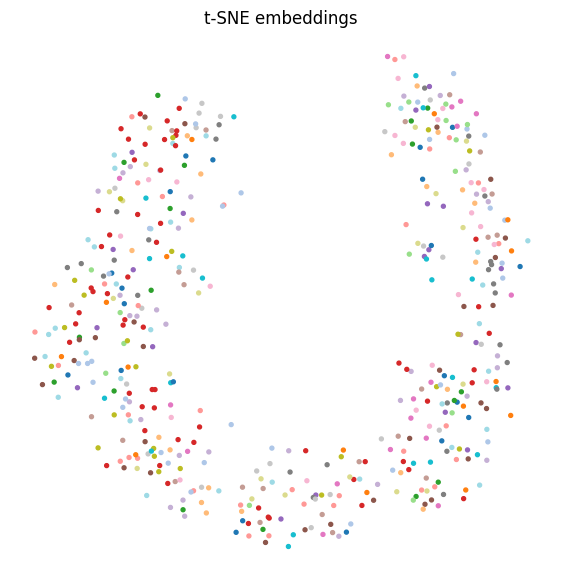

In [23]:
# ====================================================================================
# CELL 4 – MobileNetV2 experiments
# ====================================================================================
arch_name = 'MobileNetV2'
Arch = MobileNetBackbone

for loss_name, loss_fn in loss_funcs.items():
    print(f'\n=== {arch_name} + {loss_name} ===')
    model = Siamese(Arch().to(DEVICE))
    opt = optim.Adam(model.parameters(), lr=1e-3)

    if loss_name == 'InfoNCE':
        def epoch():
            model.train(); running = 0
            for x1, x2, _ in train_loader_pairs:
                x = torch.cat([x1, x2], 0).to(DEVICE)
                opt.zero_grad()
                loss = loss_fn(model.embed(x))
                loss.backward(); opt.step()
                running += loss.item() * x1.size(0)
            return running / len(train_loader_pairs.dataset)
        train_fn = epoch
    else:
        train_fn = lambda: train_epoch_siam(model, train_loader_pairs, loss_fn, opt)

    for ep in range(3):
        l = train_fn(); print(f'Epoch {ep+1}: loss {l:.4f}')
    auc, acc, th = evaluate(model, test_loader_pairs)
    print(f'→ AUC {auc:.3f} | Acc {acc:.3f} @ thr {th:.2f}')
    results.append(dict(Arch=arch_name, Loss=loss_name, AUC=auc, Acc=acc, Threshold=th))

print(f'\n=== {arch_name} + Triplet ===')
model = Siamese(Arch().to(DEVICE))
opt = optim.Adam(model.parameters(), lr=1e-3)
for ep in range(3):
    l = train_epoch_triplet(model, train_loader_trip, TripletLoss(), opt)
    print(f'Epoch {ep+1}: loss {l:.4f}')
auc, acc, th = evaluate(model, test_loader_pairs)
results.append(dict(Arch=arch_name, Loss='Triplet', AUC=auc, Acc=acc, Threshold=th))
plot_tsne(model, test_base, min(500, len(test_base))); plt.show()


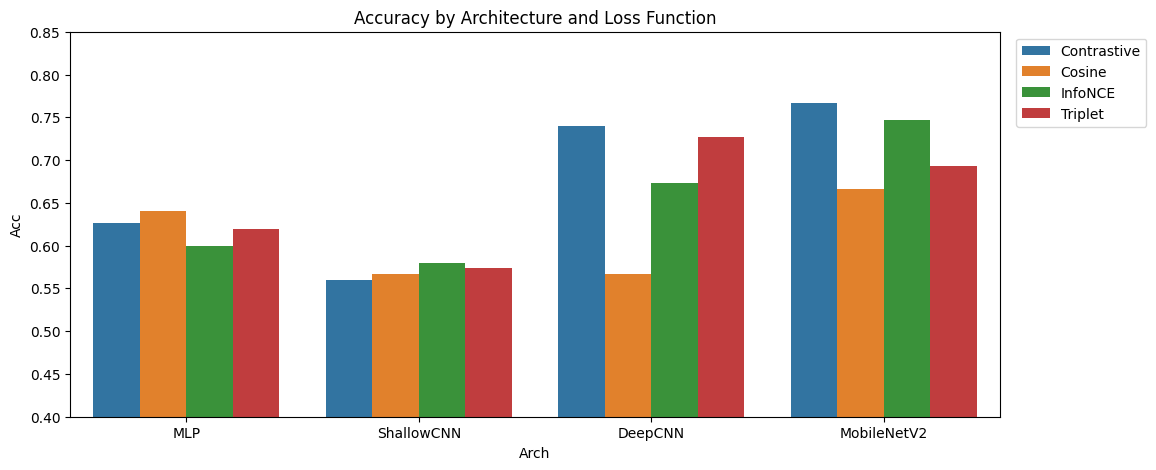

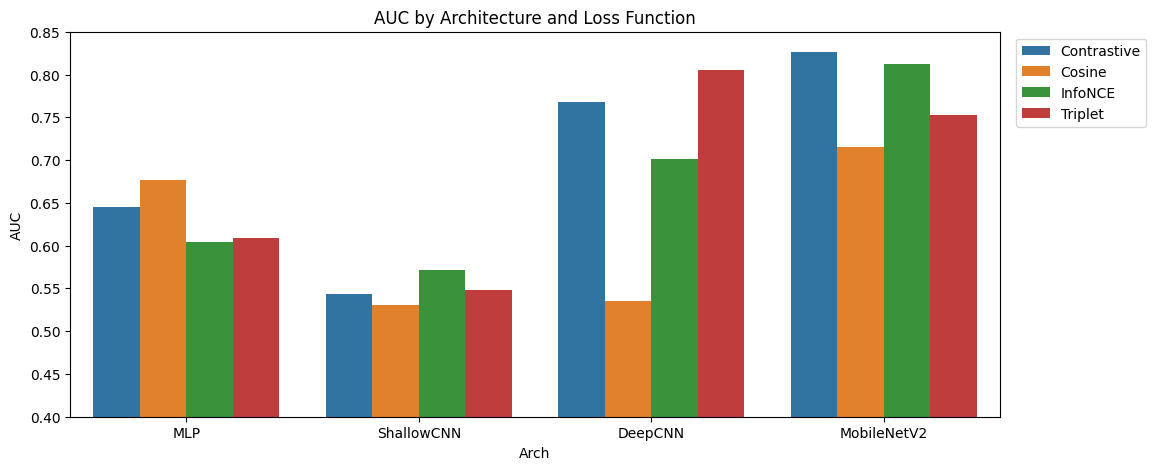

In [24]:
# ====================================================================================
# CELL 5 – Final Results Visualization
# ====================================================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Plot Accuracy and AUC by Arch/Loss
plt.figure(figsize=(12, 5))
sns.barplot(data=df_results, x='Arch', y='Acc', hue='Loss')
plt.title('Accuracy by Architecture and Loss Function')
plt.ylim(0.4, 0.85)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(data=df_results, x='Arch', y='AUC', hue='Loss')
plt.title('AUC by Architecture and Loss Function')
plt.ylim(0.4, 0.85)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()


In [ ]:
def show_pair_prediction(model, dataset, threshold=0.5):
    model.eval()
    for x1, x2, y in dataset:
        z1 = model.embed(x1.unsqueeze(0).to(DEVICE))
        z2 = model.embed(x2.unsqueeze(0).to(DEVICE))
        sim = F.pairwise_distance(z1, z2).item()

        plt.figure(figsize=(4, 2))
        plt.subplot(1, 2, 1)
        plt.imshow(x1.squeeze(0), cmap='gray')
        plt.title("Face 1")

        plt.subplot(1, 2, 2)
        plt.imshow(x2.squeeze(0), cmap='gray')
        plt.title("Face 2")

        plt.suptitle(f'True: {y}, Distance: {sim:.2f} → {"Match" if sim<threshold else "No Match"}')
        plt.show()

        break  # show one pair only



=== MLP + Contrastive ===
Epoch 1: loss 0.3121
Epoch 2: loss 0.2439
Epoch 3: loss 0.2047
→ AUC 0.532 | Acc 0.567 @ thr 0.87

=== MLP + Cosine ===
Epoch 1: loss 0.5097
Epoch 2: loss 0.4807
Epoch 3: loss 0.3963
→ AUC 0.564 | Acc 0.593 @ thr 0.84

=== MLP + InfoNCE ===
Epoch 1: loss 3.7365
Epoch 2: loss 3.5438
Epoch 3: loss 3.4362
→ AUC 0.507 | Acc 0.533 @ thr 0.84

=== MLP + Triplet ===
Epoch 1: loss 0.8710
Epoch 2: loss 0.7807
Epoch 3: loss 0.6830


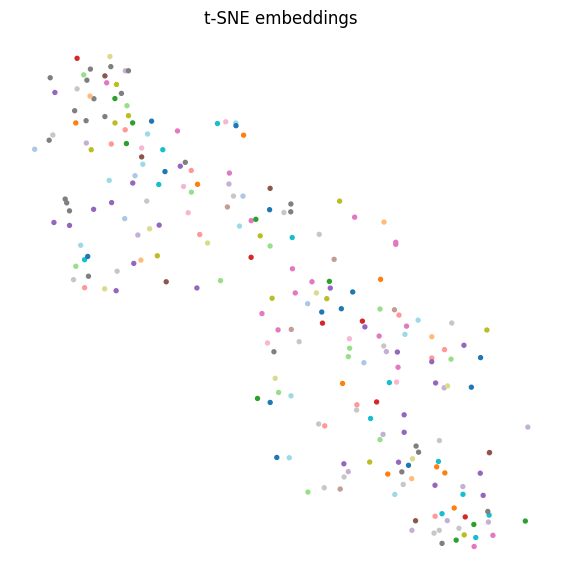


=== ShallowCNN + Contrastive ===
Epoch 1: loss 0.3010
Epoch 2: loss 0.2794
Epoch 3: loss 0.2734
→ AUC 0.440 | Acc 0.513 @ thr 0.76

=== ShallowCNN + Cosine ===
Epoch 1: loss 0.5060
Epoch 2: loss 0.5002
Epoch 3: loss 0.5001
→ AUC 0.486 | Acc 0.513 @ thr 0.99

=== ShallowCNN + InfoNCE ===
Epoch 1: loss 3.8618
Epoch 2: loss 3.7274
Epoch 3: loss 3.6100
→ AUC 0.448 | Acc 0.513 @ thr 0.76

=== ShallowCNN + Triplet ===
Epoch 1: loss 0.9866
Epoch 2: loss 0.9560
Epoch 3: loss 0.9469


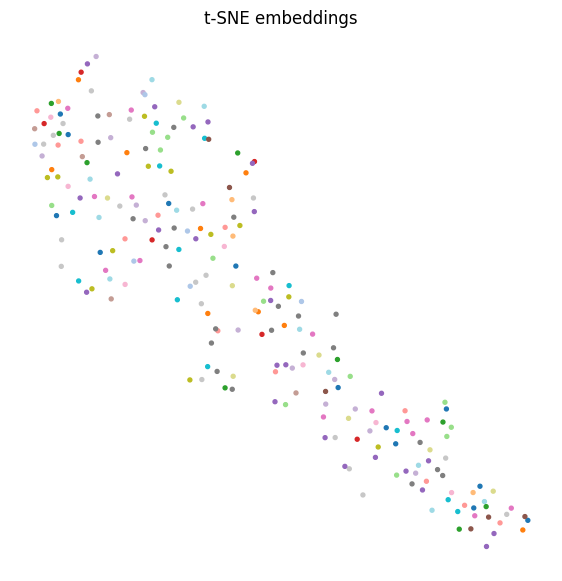


=== DeepCNN + Contrastive ===
Epoch 1: loss 0.2271
Epoch 2: loss 0.1618
Epoch 3: loss 0.1481
→ AUC 0.680 | Acc 0.647 @ thr 0.88

=== DeepCNN + Cosine ===
Epoch 1: loss 0.4596
Epoch 2: loss 0.3416
Epoch 3: loss 0.4014
→ AUC 0.396 | Acc 0.500 @ thr -1.00

=== DeepCNN + InfoNCE ===
Epoch 1: loss 2.7706
Epoch 2: loss 2.6217
Epoch 3: loss 2.3793
→ AUC 0.746 | Acc 0.707 @ thr 0.88

=== DeepCNN + Triplet ===
Epoch 1: loss 0.6329
Epoch 2: loss 0.5615
Epoch 3: loss 0.5696


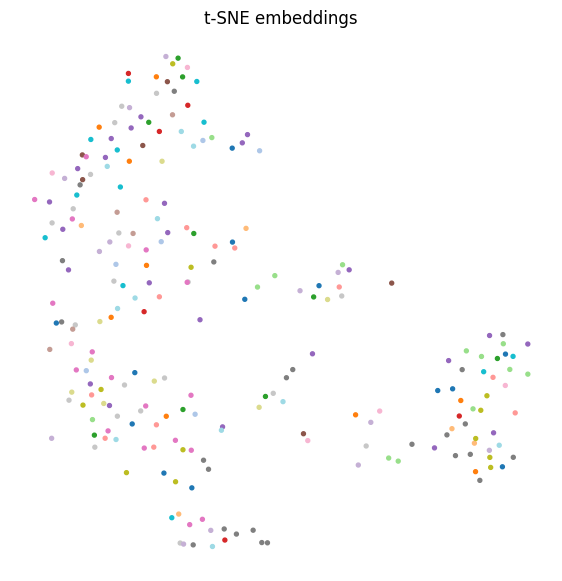


=== MobileNetV2 + Contrastive ===
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\premy/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:13<00:00, 1.06MB/s]


Epoch 1: loss 0.2878
Epoch 2: loss 0.1968
Epoch 3: loss 0.1226
→ AUC 0.663 | Acc 0.633 @ thr 0.80

=== MobileNetV2 + Cosine ===
Epoch 1: loss 0.4739
Epoch 2: loss 0.2980
Epoch 3: loss 0.1875
→ AUC 0.713 | Acc 0.673 @ thr 0.26

=== MobileNetV2 + InfoNCE ===
Epoch 1: loss 3.3266
Epoch 2: loss 2.5025
Epoch 3: loss 2.1655
→ AUC 0.749 | Acc 0.733 @ thr 0.71

=== MobileNetV2 + Triplet ===


: 

In [ ]:
# ====================================================================================
# CELL 11 – Run experiments
# ====================================================================================
'''
architectures = {
    'MLP':        MLPBackbone,
    'ShallowCNN': ShallowCNN,
    'DeepCNN':    DeepCNN,
    'MobileNetV2':MobileNetBackbone
}

loss_funcs = {
    'Contrastive': ContrastiveLoss(),
    'Cosine':      lambda z1,z2,y: cos_emb_loss(z1,z2,(2*y-1)),
    'InfoNCE':     InfoNCELoss(),   # handled specially below
}

results = []

for arch_name, Arch in architectures.items():
    for loss_name, loss_fn in loss_funcs.items():
        print(f'\n=== {arch_name} + {loss_name} ===')
        model = Siamese(Arch().to(DEVICE))
        opt   = optim.Adam(model.parameters(), lr=1e-3)
        
        # pick train loop
        if loss_name=='InfoNCE':
            def epoch():  # custom loop – positive pairs stacked
                model.train(); running=0
                for x1,x2,_ in train_loader_pairs:
                    x = torch.cat([x1,x2],0).to(DEVICE)
                    opt.zero_grad()
                    loss = loss_fn(model.embed(x))
                    loss.backward(); opt.step()
                    running += loss.item()*x1.size(0)
                return running/len(train_loader_pairs.dataset)
            train_fn = epoch
        else:
            train_fn = lambda: train_epoch_siam(model,train_loader_pairs,
                                                loss_fn,opt)
        
        for ep in range(3):  # quick demo – raise to 10+ for real runs
            l = train_fn(); print(f'Epoch {ep+1}: loss {l:.4f}')
        auc, acc, th = evaluate(model,test_loader_pairs)
        print(f'→ AUC {auc:.3f} | Acc {acc:.3f} @ thr {th:.2f}')
        results.append(dict(Arch=arch_name,Loss=loss_name,
                            AUC=auc,Acc=acc,Threshold=th))
    
    # Triplet loss separately
    print(f'\n=== {arch_name} + Triplet ===')
    model = Siamese(Arch().to(DEVICE))
    opt   = optim.Adam(model.parameters(),1e-3)
    for ep in range(3):
        l = train_epoch_triplet(model,train_loader_trip,
                                TripletLoss(),opt)
        print(f'Epoch {ep+1}: loss {l:.4f}')
    auc, acc, th = evaluate(model,test_loader_pairs)
    results.append(dict(Arch=arch_name,Loss='Triplet',
                        AUC=auc,Acc=acc,Threshold=th))
    n_samples = min(800, len(test_base))
    plot_tsne(model, test_base, n_samples)
    plt.show()
'''


=== MLP + Contrastive ===
Epoch 1: loss 0.3121
Epoch 2: loss 0.2439
Epoch 3: loss 0.2047
→ AUC 0.532 | Acc 0.567 @ thr 0.87

=== MLP + Cosine ===
Epoch 1: loss 0.5097
Epoch 2: loss 0.4807
Epoch 3: loss 0.3963
→ AUC 0.564 | Acc 0.593 @ thr 0.84

=== MLP + InfoNCE ===
Epoch 1: loss 3.7365
Epoch 2: loss 3.5438
Epoch 3: loss 3.4362
→ AUC 0.507 | Acc 0.533 @ thr 0.84

=== MLP + Triplet ===
Epoch 1: loss 0.8710
Epoch 2: loss 0.7807
Epoch 3: loss 0.6830


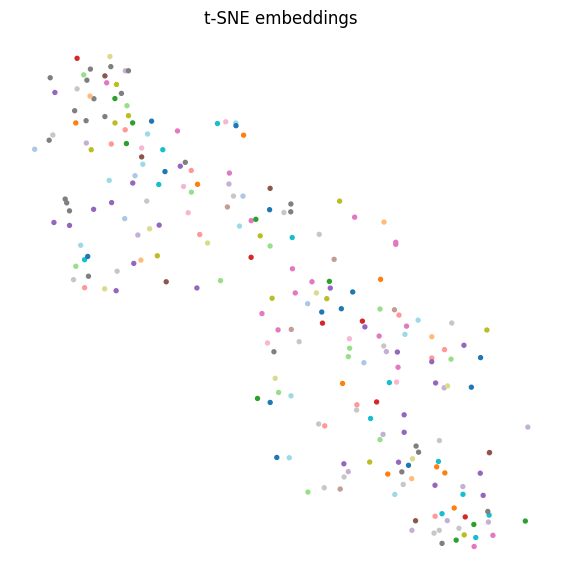


=== ShallowCNN + Contrastive ===
Epoch 1: loss 0.3010
Epoch 2: loss 0.2794
Epoch 3: loss 0.2734
→ AUC 0.440 | Acc 0.513 @ thr 0.76

=== ShallowCNN + Cosine ===
Epoch 1: loss 0.5060
Epoch 2: loss 0.5002
Epoch 3: loss 0.5001
→ AUC 0.486 | Acc 0.513 @ thr 0.99

=== ShallowCNN + InfoNCE ===
Epoch 1: loss 3.8618
Epoch 2: loss 3.7274
Epoch 3: loss 3.6100
→ AUC 0.448 | Acc 0.513 @ thr 0.76

=== ShallowCNN + Triplet ===
Epoch 1: loss 0.9866
Epoch 2: loss 0.9560
Epoch 3: loss 0.9469


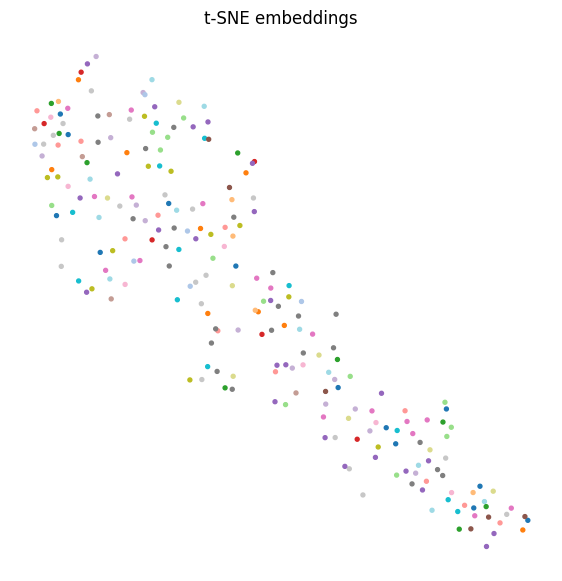


=== DeepCNN + Contrastive ===
Epoch 1: loss 0.2271
Epoch 2: loss 0.1618
Epoch 3: loss 0.1481
→ AUC 0.680 | Acc 0.647 @ thr 0.88

=== DeepCNN + Cosine ===
Epoch 1: loss 0.4596
Epoch 2: loss 0.3416
Epoch 3: loss 0.4014
→ AUC 0.396 | Acc 0.500 @ thr -1.00

=== DeepCNN + InfoNCE ===
Epoch 1: loss 2.7706
Epoch 2: loss 2.6217
Epoch 3: loss 2.3793
→ AUC 0.746 | Acc 0.707 @ thr 0.88

=== DeepCNN + Triplet ===
Epoch 1: loss 0.6329
Epoch 2: loss 0.5615
Epoch 3: loss 0.5696


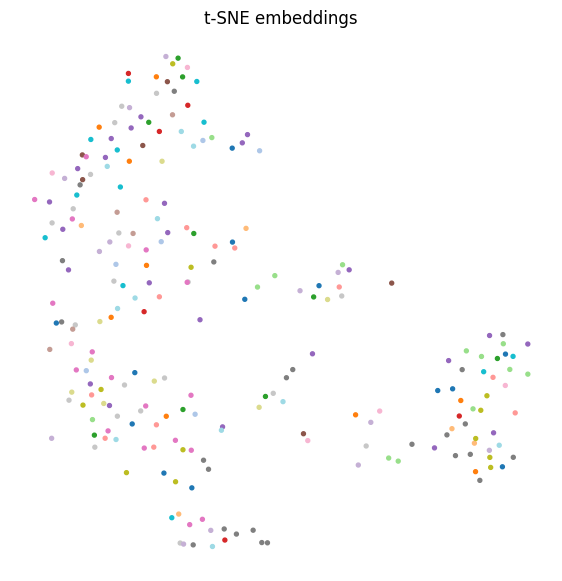


=== MobileNetV2 + Contrastive ===
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\premy/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:13<00:00, 1.06MB/s]


Epoch 1: loss 0.2878
Epoch 2: loss 0.1968
Epoch 3: loss 0.1226
→ AUC 0.663 | Acc 0.633 @ thr 0.80

=== MobileNetV2 + Cosine ===
Epoch 1: loss 0.4739
Epoch 2: loss 0.2980
Epoch 3: loss 0.1875
→ AUC 0.713 | Acc 0.673 @ thr 0.26

=== MobileNetV2 + InfoNCE ===
Epoch 1: loss 3.3266
Epoch 2: loss 2.5025
Epoch 3: loss 2.1655
→ AUC 0.749 | Acc 0.733 @ thr 0.71

=== MobileNetV2 + Triplet ===


: 

In [ ]:
# ====================================================================================
# CELL 11 – Run experiments
# ====================================================================================

architectures = {
    'MLP':        MLPBackbone,
    'ShallowCNN': ShallowCNN,
    'DeepCNN':    DeepCNN,
    'MobileNetV2':MobileNetBackbone
}

loss_funcs = {
    'Contrastive': ContrastiveLoss(),
    'Cosine':      lambda z1,z2,y: cos_emb_loss(z1,z2,(2*y-1)),
    'InfoNCE':     InfoNCELoss(),   # handled specially below
}

results = []

for arch_name, Arch in architectures.items():
    for loss_name, loss_fn in loss_funcs.items():
        print(f'\n=== {arch_name} + {loss_name} ===')
        model = Siamese(Arch().to(DEVICE))
        opt   = optim.Adam(model.parameters(), lr=1e-3)
        
        # pick train loop
        if loss_name=='InfoNCE':
            def epoch():  # custom loop – positive pairs stacked
                model.train(); running=0
                for x1,x2,_ in train_loader_pairs:
                    x = torch.cat([x1,x2],0).to(DEVICE)
                    opt.zero_grad()
                    loss = loss_fn(model.embed(x))
                    loss.backward(); opt.step()
                    running += loss.item()*x1.size(0)
                return running/len(train_loader_pairs.dataset)
            train_fn = epoch
        else:
            train_fn = lambda: train_epoch_siam(model,train_loader_pairs,
                                                loss_fn,opt)
        
        for ep in range(3):  # quick demo – raise to 10+ for real runs
            l = train_fn(); print(f'Epoch {ep+1}: loss {l:.4f}')
        auc, acc, th = evaluate(model,test_loader_pairs)
        print(f'→ AUC {auc:.3f} | Acc {acc:.3f} @ thr {th:.2f}')
        results.append(dict(Arch=arch_name,Loss=loss_name,
                            AUC=auc,Acc=acc,Threshold=th))
    
    # Triplet loss separately
    print(f'\n=== {arch_name} + Triplet ===')
    model = Siamese(Arch().to(DEVICE))
    opt   = optim.Adam(model.parameters(),1e-3)
    for ep in range(3):
        l = train_epoch_triplet(model,train_loader_trip,
                                TripletLoss(),opt)
        print(f'Epoch {ep+1}: loss {l:.4f}')
    auc, acc, th = evaluate(model,test_loader_pairs)
    results.append(dict(Arch=arch_name,Loss='Triplet',
                        AUC=auc,Acc=acc,Threshold=th))
    n_samples = min(800, len(test_base))
    plot_tsne(model, test_base, n_samples)
    plt.show()


In [ ]:
# ====================================================================================
# CELL 12 – Results table & heatmaps
# ====================================================================================

df = pd.DataFrame(results).round(3)
print(df)

plt.figure(figsize=(10,4))
pivot_auc = df.pivot('Arch','Loss','AUC')
sns.heatmap(pivot_auc, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('AUC Heatmap'); plt.show()

pivot_acc = df.pivot('Arch','Loss','Acc')
sns.heatmap(pivot_acc, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Accuracy Heatmap'); plt.show()

df.to_csv('siamese_arch_loss_results.csv', index=False)
print('Saved results to siamese_arch_loss_results.csv')
